### Introduction

In the previous post, we implemented the upsampling and made sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we had _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.

In this post we will perform a simple training: we will get a sample image from
[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset along with annotation,
train our network on them and test our network on the same image. It was done this way
so that it can also be run on CPU -- it takes only 10 iterations for the training to complete.
Another point of this post is to show that segmentation that our network (FCN-32s) produces is
very coarse -- even if we run it on the same image that we were training it on. In this post
we tackle this problem by performing Conditional Random Field post-processing stage, which
refines our segmentation by taking into account pure RGB features of image and probabilities
produced by our network. Overall, we get a refined segmentation. The set-up of this post
is very simple on purpose. Similar approach to Segmentation was described in the paper
_Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al.

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.12_.
You will need to use [this fork of _tensorflow/models_](https://github.com/tensorflow/models/pull/684). 

I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

Follow all the other steps described in the previous posts -- it shows how to download
the _VGG-16_ model and I also forked the 

In [1]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np
from nets import vgg
from preprocessing import vgg_preprocessing
from libs.scale_input_image import scale_randomly_image_with_annotation_with_fixed_size_output, flip_randomly_left_right_image_with_annotation
from libs.training import get_valid_logits_and_labels

# Mean values for VGG-16
from preprocessing.vgg_preprocessing import _R_MEAN, _G_MEAN, _B_MEAN

# Data processing

In [2]:
#0:   background
#1:   aeroplane
#2:   bicycle
#3:   bird
#4:   boat
#5:   bottle
#6:   bus
#7:   car
#8:   cat
#9:   chair
#10:  cow
#11:  diningtable
#12:  dog
#13:  horse
#14:  motorbike
#15:  person
#16:  pottedplant
#17:  sheep
#18:  sofa
#19:  train
#20:  tvmonitor
#255: undefined/don't care
number_of_classes = 21
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

### Upsampling helper functions and Image Loading

In this part, we define helper functions that were used in previous post.
If you recall, we used upsampling to upsample the downsampled predictions
that we get from our network. We get downsampled predictions because of max-pooling
layers that are used in _VGG-16_ network.

We also write code for image and respective ground-truth segmentation loading.
The code is well-commented, so don't be afraid to read it.

In [3]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights

#def _mean_image_subtraction(image, means):
#    """Subtracts the given means from each image channel.
#
#    For example:
#    means = [123.68, 116.779, 103.939]
#    image = _mean_image_subtraction(image, means)
#
#    Note that the rank of `image` must be known.
#
#    Args:
#    image: a tensor of size [height, width, C].
#    means: a C-vector of values to subtract from each channel.
#
#    Returns:
#    the centered image.

# """
# if image.get_shape().ndims != 4:
#     raise ValueError('Input must be of size [height, width, C>0]')
# num_channels = image.get_shape().as_list()[-1]
# 
# if len(means) != num_channels:
#     raise ValueError('len(means) must match the number of channels')
# 
# channels = tf.split(axis=3, num_or_size_splits=num_channels, value=image)
# for i in range(num_channels):
#     channels[i] -= means[i]
# 
# return tf.concat(axis=3, values=channels)

In [4]:
sys.path.append("/home/thalles/VOC2012/JPEGImages/")
checkpoints_dir = '/home/thalles/image-segmentation/vgg'
log_folder = '/home/thalles/log_folder'
vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

In [5]:
training_filenames = "/home/thalles/image-segmentation/training_filenames.txt"
validation_file = "/home/thalles/image-segmentation/validation_filenames.txt"
testing_file = "/home/thalles/image-segmentation/testing_filenames.txt"
training_images_dir = "/home/thalles/VOC2012/JPEGImages/"
training_labels_dir = "/home/thalles/VOC2012/SegmentationClass_1D/"
#training_filenames = ["2007_000170"]

In [6]:
def model_input():
    is_training_placeholder = tf.placeholder(tf.bool)
    return is_training_placeholder

### Loss function definition and training using Adam Optimization Algorithm.

In [7]:
import sys
import os
from matplotlib import pyplot as plt

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

slim = tf.contrib.slim

# Create an array to represent the filter to be applied
# in the transpose convolution op with shape [height, width, output_channels, in_channels]
upsample_filter_factor_2_np = bilinear_upsample_weights(factor=2,
                                                        number_of_classes=number_of_classes)

upsample_filter_factor_16_np = bilinear_upsample_weights(factor=16,
                                                         number_of_classes=number_of_classes)

upsample_filter_factor_2_tensor = tf.constant(upsample_filter_factor_2_np)
upsample_filter_factor_16_tensor = tf.constant(upsample_filter_factor_16_np)

def model(processed_images, number_of_classes=21, is_training=True):
    
    # Subtract the mean pixel value from each pixel
    mean_centered_image_batch = processed_images - [_R_MEAN, _G_MEAN, _B_MEAN]
    
    # Define the model that we want to use -- specify to use only two classes at the last layer
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, vgg_variables = vgg.vgg_16(mean_centered_image_batch,
                               num_classes=number_of_classes,
                               is_training=is_training,
                               spatial_squeeze=False)

    # get the vggs pool5 feature map
    pool5_feature_map = vgg_variables['vgg_16/pool5']

    pool5_logits = slim.conv2d(pool5_feature_map,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               scope="seg_vars/pool5",
                               weights_initializer=tf.zeros_initializer) # Out: # (1, 22, 30, 2)

    final_logits_plus_poo5_logits = logits + pool5_logits
    # final_logits_plus_poo5_logits = logits 

    # Returns the shape of tensor logits. 
    # For that particular input image we get (1, 11, 15, 2)
    downsampled_logits_shape = tf.shape(final_logits_plus_poo5_logits)

    # Calculate the ouput size of the upsampled tensor
    upsampled_logits_shape = tf.stack([
                                      downsampled_logits_shape[0],
                                      downsampled_logits_shape[1] * 2, 
                                      downsampled_logits_shape[2] * 2, 
                                      downsampled_logits_shape[3]
                                     ]) # Output [1 22 30 2] - Note the original input image size

    # Perform the first upsampling by applying a convolution to the conv8 layer of the vgg
    # at stride 32 (paper)
    upsampled_logits = tf.nn.conv2d_transpose(final_logits_plus_poo5_logits, # (1, 11, 15, 2)
                                             upsample_filter_factor_2_tensor, # (64, 64, 2, 2) # convolutonal filter shape
                                             output_shape=upsampled_logits_shape, # [1 352 480 2] # Output shape of the conv op
                                             strides=[1, 2, 2, 1]) # [1 x 32 x 32 x 1]

    # We add a 1 × 1 convolution layer on top of pool4 to produce additional class predictions
    pool4_feature_map = vgg_variables['vgg_16/pool4']
    
    # The new parameters acting on pool4 are zero-initialized so that the net starts with unmodified predictions (paper)
    pool4_logits = slim.conv2d(pool4_feature_map,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               scope="seg_vars/pool4",
                               weights_initializer=tf.zeros_initializer) # Out: # (1, 22, 30, 2)


    # sum the last layers transpose features with the vgg pool 4 features
    conv7_plus_pool4_logits = pool4_logits + upsampled_logits
    conv7_plus_pool4_logits_shape  = tf.shape(conv7_plus_pool4_logits)


    conv7_pool4_upsampled_by_factor_16_logits_shape = tf.stack([
                                                              conv7_plus_pool4_logits_shape[0],
                                                              conv7_plus_pool4_logits_shape[1] * 16,
                                                              conv7_plus_pool4_logits_shape[2] * 16,
                                                              conv7_plus_pool4_logits_shape[3]
                                                             ])

    # Perform the upsampling
    upsampled_by_factor_16_logits = tf.nn.conv2d_transpose(conv7_plus_pool4_logits,
                                                            upsample_filter_factor_16_tensor,
                                                            output_shape=conv7_pool4_upsampled_by_factor_16_logits_shape,
                                                            strides=[1, 16, 16, 1])


    # Flatten the predictions, so that we can compute cross-entropy for
    # each pixel and get the sum of cross-entropies.
    # From: (1, 352, 480, 2) to (352*480, 2).
    # Note, here the flat logits shape matches the flat_labels shape. That is necessary for cross-entropy
    flat_logits = tf.reshape(tensor=upsampled_by_factor_16_logits, shape=(-1, number_of_classes))
    return flat_logits, upsampled_by_factor_16_logits

In [8]:
def model_loss(upsampled_by_factor_16_logits, labels):
    labels = tf.squeeze(labels)
    valid_labels_batch_tensor, valid_logits_batch_tensor = get_valid_logits_and_labels(annotation_batch_tensor=labels,
                                                                                       logits_batch_tensor=upsampled_by_factor_16_logits,
                                                                                       class_labels=class_labels)



    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=valid_logits_batch_tensor,
                                                              labels=valid_labels_batch_tensor)

    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
    probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)
    
    return cross_entropy_mean, pred, probabilities

In [9]:
def model_optimizer(cross_entropy_sum, learning_rate):
    # Here we define an optimizer and put all the variables
    # that will be created under a namespace of 'adam_vars'.
    # This is done so that we can easily access them later.
    # Those variables are used by adam optimizer and are not
    # related to variables of the vgg model.

    # We also retrieve gradient Tensors for each of our variables
    # This way we can later visualize them in tensorboard.
    # optimizer.compute_gradients and optimizer.apply_gradients
    # is equivalent to running:
    # train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
    with tf.variable_scope("adam_vars"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        gradients = optimizer.compute_gradients(loss=cross_entropy_sum)

        for grad_var_pair in gradients:

            current_variable = grad_var_pair[1]
            current_gradient = grad_var_pair[0]

            # Relace some characters from the original variable name
            # tensorboard doesn't accept ':' symbol
            gradient_name_to_save = current_variable.name.replace(":", "_")

            # Let's get histogram of gradients for each layer and
            # visualize them later in tensorboard
            # tf.summary.histogram(gradient_name_to_save, current_gradient) 

        train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    return train_step

In [10]:
num_classes = 21
input_shape = (384,384,3)
annotation_shape = (384,384)
batch_size = 6
image_size=[384, 384]
total_train_steps = 13110

In [11]:
filename_queue = tf.train.string_input_producer([training_filenames])
reader = tf.TextLineReader()
key, img_filename = reader.read(filename_queue)

# read the input and annotation images
image_tensor = tf.read_file(training_images_dir + img_filename + ".jpg")
annotation_tensor = tf.read_file(training_labels_dir + img_filename + ".png")

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

# Randomly flip the image horizontally.
image_tensor, annotation_tensor = flip_randomly_left_right_image_with_annotation(image_tensor, annotation_tensor)

image_tensor = tf.image.random_brightness(image_tensor, max_delta=63)
image_tensor = tf.image.random_contrast(image_tensor, lower=0.6, upper=1.4)

resized_image, resized_annotation = scale_randomly_image_with_annotation_with_fixed_size_output(image_tensor, annotation_tensor, image_size)

num_examples_per_epoch = len(training_filenames)
min_fraction_of_examples_in_queue = 0.4
min_queue_examples = int(num_examples_per_epoch * min_fraction_of_examples_in_queue)

# Create a queue that shuffles the examples, and then
# read 'batch_size' images + labels from the example queue.
num_preprocess_threads = 2
batch_images, batch_labels = tf.train.shuffle_batch(
    [resized_image, resized_annotation],
    batch_size=batch_size,
    num_threads=num_preprocess_threads,
    capacity=min_queue_examples + 3 * batch_size,
    min_after_dequeue=min_queue_examples)

In [12]:
# with tf.Session() as sess:
#     # Start input enqueue threads.
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(sess=sess, coord=coord)
# 
#     try:
#         iii, lll = sess.run([batch_images, batch_labels])
#         print(iii.shape)
# 
#         f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#         f.set_figheight(4)
#         f.set_figwidth(16)
# 
#         ax1.imshow(iii[0])
#         ax2.imshow(np.dstack((lll[0].astype(float),)*3)*100)
#         plt.show()
#     except tf.errors.OutOfRangeError:
#         print('Done training -- epoch limit reached')
#     finally:
#         # When done, ask the threads to stop.
#         coord.request_stop()
# 
#     # Wait for threads to finish.
#     coord.join(threads)

In [13]:
is_training_placeholder = model_input()

flat_logits, upsampled_by_factor_16_logits = model(batch_images, number_of_classes=num_classes, is_training=True)

cross_entropy_sum, pred, probabilities = model_loss(upsampled_by_factor_16_logits, batch_labels)

train_step = model_optimizer(cross_entropy_sum, learning_rate=0.000001)

In [14]:
# Define the accuracy metric: Mean Intersection Over Union
miou, update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=tf.squeeze(batch_labels),
                                                   num_classes=number_of_classes)

In [15]:
# get all segmentation model vars, these are the variables we create to perform 
# the segmentation upsampling layers
model_variables = [ var.op.name for var in slim.get_variables(scope="seg_vars") ]

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
exclude_vars = model_variables + ['vgg_16/fc8', 'adam_vars']
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=exclude_vars)

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# get the segmentation upsampling variables to be initialized 
model_variables = slim.get_variables(scope="seg_vars")

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# the VGG net variables.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

INFO:tensorflow:Restoring parameters from /home/thalles/image-segmentation/vgg/vgg_16.ckpt
Train step: 0 	Traing Loss: 3.31384 	mIOU: 0.00484018


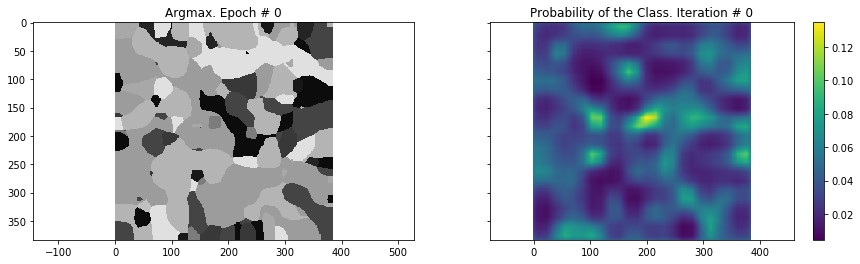

Train step: 100 	Traing Loss: 0.978313 	mIOU: 0.0338583


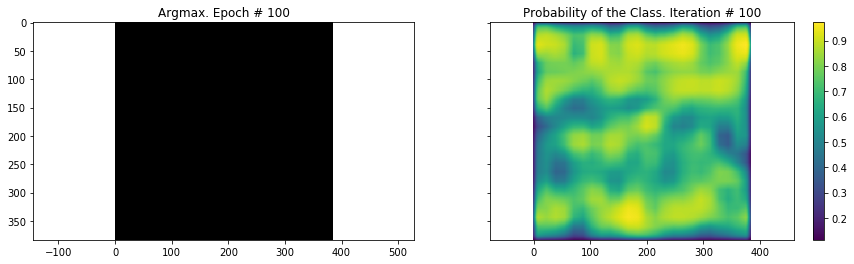

In [ ]:
# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

model_vars = tf.variables_initializer(model_variables)

# Create a saver.
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    sess.run(tf.local_variables_initializer())
    sess.run(model_vars)
    global_step = 0

    # Start input enqueue threads.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:

        for batch_id in range(total_train_steps):

            _, train_loss, summary_string, tmp = sess.run([train_step, cross_entropy_sum, merged_summary_op, update_op],
                                            feed_dict={is_training_placeholder: True})

            if global_step % 100 == 0:

                summary_string_writer.add_summary(summary_string, global_step)
                
                miou_np = sess.run(miou)
                print("Train step:", global_step, "\tTraing Loss:", train_loss, "\tmIOU:", miou_np)

                pred_np, probabilities_np = sess.run([pred, probabilities],
                                                      feed_dict={is_training_placeholder: False})

                cmap = plt.get_cmap('bwr')

                f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

                pred_annotation = np.expand_dims(pred_np[0], axis=2).astype(float)
                ax1.imshow(np.dstack((pred_annotation,)*3)*100)

                ax1.set_title('Argmax. Epoch # ' + str(global_step))
                probability_graph = ax2.imshow(probabilities_np[0].squeeze()[:, :, 0])
                ax2.set_title('Probability of the Class. Iteration # ' + str(global_step))

                plt.colorbar(probability_graph)
                plt.show()

                # Append the step number to the checkpoint name:
                saver.save(sess, './checkpoints_2/FCNCheckpoints', global_step=global_step)

            global_step += 1
        
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()
        
    # Wait for threads to finish.
    coord.join(threads)
    sess.close()

    summary_string_writer.close()

In [ ]:
image_name = "./images/cat"
image_tensor = tf.read_file(image_name + ".jpg")
image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
image_tensor = tf.cast(tf.expand_dims(image_tensor, axis=0), tf.float32)
#image_tensor = tf.image.resize_images(image_tensor, (416,448))

In [ ]:
is_training_placeholder = model_input()
flat_logits, upsampled_by_factor_16_logits = model(image_tensor, number_of_classes=21, is_training=False)
pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "checkpoints/FCNCheckpoints-9999")
    print("Model restored.")
    
    pred_np, probabilities_np, image = sess.run([pred, probabilities, image_tensor],
                                          feed_dict={is_training_placeholder: False})
    print(image.shape)
    cmap = plt.get_cmap('bwr')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(image.squeeze()[:, :, 0])
    probability_graph = ax2.imshow(probabilities_np[0].squeeze()[:, :, 0])

    plt.colorbar(probability_graph)
    plt.show()

(1, 352, 480, 3)


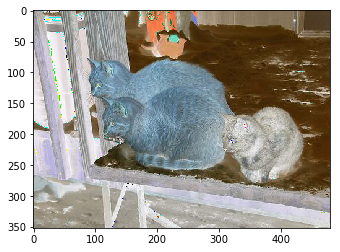

In [11]:
print(image.shape)
plt.imshow(image[0])

(1, 352, 480)


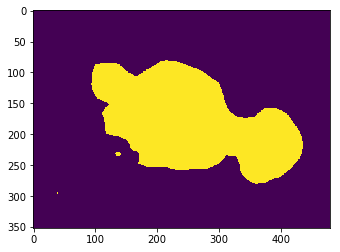

In [12]:
print(pred_np.shape)
plt.imshow(np.squeeze(pred_np))